## NEAT - Dawid Przybyliński 298836

In [1]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ConnectionGene:
    def __init__(self, inNode, outNode, weight, innov, enabled=True):
        self.inNode = inNode
        self.outNode = outNode
        self.weight = weight
        self.enabled = enabled
        self.innov = innov

class NodeGene:
    def __init__(self, node_id, node_type, bias=None, h=0):
        self.node_id = node_id
        self.node_type = node_type
        self.h = h
        if bias:
            self.bias = bias
        else:
            self.bias = np.random.uniform(-1,1)
        
class specimen:
    def __init__(self, num_input, num_output):
        self.next_node_id = num_input + num_output
        
        input_part = [NodeGene(i, 'input') for i in range(num_input)]
        output_part = [NodeGene(i, 'output', h=1.0) for i in range(num_input, num_input + num_output, 1)]
        self.node_genes = input_part + output_part
        
        self.conn_genes = []
        innov_init_idx = 0
        for i in range(num_input):
            for j in range(num_input, num_input + num_output, 1):
                self.conn_genes.append(ConnectionGene(i, j, np.random.uniform(-1,1), innov_init_idx))
                innov_init_idx += 1
        
class NEAT:
    def __init__(self, n, num_input, num_output):
        self.n = n
        self.num_input = num_input
        self.num_output = num_output
        self.innov_counter = num_input * num_output
        self.conn_innov_dict = []
        self.generation_mean = []
        
    # FUNKCJE INICJALIZACJI
        
    def initialize(self):
        self.population = [specimen(self.num_input, self.num_output) for i in range(self.n)]
        
    def add_node_calc_innov(self, conn_innov):
        for pair in self.conn_innov_dict:
            if pair[0] == conn_innov:
                return [pair[1], pair[1]+1]
        self.innov_counter += 2
        self.conn_innov_dict.append([conn_innov, self.innov_counter - 2])
        return [self.innov_counter - 2, self.innov_counter - 1] 
    
    # FUNKCJE MUTACJI
        
    def add_node_mutation(self, specimen_before: specimen):
        specimen = copy.deepcopy(specimen_before)
        conn = specimen.conn_genes[np.random.randint(0,len(specimen.conn_genes))]
        if not conn.enabled:
            return specimen_before
        conn.enabled = False
        new_node_id = specimen.next_node_id
        specimen.next_node_id += 1
        h_in = specimen.node_genes[conn.inNode].h
        h_out = specimen.node_genes[conn.outNode].h
        new_h = np.random.uniform(0.75*h_in + 0.25*h_out, 0.25*h_in + 0.75*h_out)
        specimen.node_genes.append(NodeGene(new_node_id, 'hidden', h=new_h))
        innovs = self.add_node_calc_innov(conn.innov)
        specimen.conn_genes.append(ConnectionGene(conn.inNode, new_node_id, np.random.uniform(-1,1), innovs[0]))
        specimen.conn_genes.append(ConnectionGene(new_node_id, conn.outNode, np.random.uniform(-1,1), innovs[1]))
        return specimen
        
    def add_conn_mutation(self, specimen_before: specimen):
        specimen = copy.deepcopy(specimen_before)
        [n1,n2] = np.random.choice(specimen.node_genes, 2, replace=False)
        conn_exists = False
        for gene in specimen.conn_genes:
            if gene.inNode == n1.node_id and gene.outNode == n2.node_id:
                conn_exists = True
        if not (n1.node_type == 'input' and n1.node_type == 'input'):
            if not (n1.node_type == 'output' and n1.node_type == 'output'):
                if not conn_exists:
                    new_innov = self.innov_counter
                    self.innov_counter += 1
                    if n1.h < n2.h:
                        specimen.conn_genes.append(ConnectionGene(n1.node_id, n2.node_id, np.random.uniform(-1,1), new_innov))
                    else:
                        specimen.conn_genes.append(ConnectionGene(n2.node_id, n1.node_id, np.random.uniform(-1,1), new_innov))
        return specimen
    
    def weight_mutation(self, specimen_before: specimen):
        specimen = copy.deepcopy(specimen_before)
        for conn in specimen.conn_genes:
            if np.random.uniform(0, 1) < 0.9:
                conn.weight *= np.random.uniform(-2, 2)
            else:
                conn.weight = np.random.uniform(-1, 1)
        return specimen
                
    def bias_mutation(self, specimen_before: specimen):
        specimen = copy.deepcopy(specimen_before)
        for node in specimen.node_genes:
            if np.random.uniform(0, 1) < 0.9:
                node.bias *= np.random.uniform(-2, 2)
            else:
                node.bias = np.random.uniform(-1, 1)
        return specimen
                
    
    # FUNCKJE KRZYŻOWANIA
    
    def cross(self, parent1: specimen, parent2: specimen):
        """
        """
        def find_conn_by_innov(specimen: specimen, innovation):
            for conn_gen in specimen.conn_genes:
                if conn_gen.innov == innovation:
                    return conn_gen
        
        child = specimen(0,0)
        
        n_1 = len(parent1.node_genes)
        n_2 = len(parent2.node_genes)
        child.node_genes = copy.deepcopy(parent1.node_genes) if n_1 >= n_2 else copy.deepcopy(parent2.node_genes)
        child.next_node_id = max(n_1, n_2)
        
        p1_conn_innov = [parent1.conn_genes[i].innov for i in range(len(parent1.conn_genes))]
        p2_conn_innov = [parent2.conn_genes[i].innov for i in range(len(parent2.conn_genes))]
        
        for innov_num in range(max(p1_conn_innov + p2_conn_innov) + 1):
            if innov_num in p1_conn_innov and innov_num in p2_conn_innov:
                if np.random.choice([1,2]) == 1:
                    new_conn = copy.deepcopy(find_conn_by_innov(parent1, innov_num))
                else:
                    new_conn = copy.deepcopy(find_conn_by_innov(parent2, innov_num))
                if (not find_conn_by_innov(parent1, innov_num).enabled) or (not find_conn_by_innov(parent2, innov_num).enabled):
                    new_conn.enabled = False
                child.conn_genes.append(new_conn)
            elif innov_num in p1_conn_innov and innov_num not in p2_conn_innov:
                new_conn = copy.deepcopy(find_conn_by_innov(parent1, innov_num))
                child.conn_genes.append(new_conn)
            elif innov_num not in p1_conn_innov and innov_num in p2_conn_innov:
                new_conn = copy.deepcopy(find_conn_by_innov(parent2, innov_num))
                child.conn_genes.append(new_conn)
                
        return child
            
                
                
    def count_crossover_genes(parent1: specimen, parent2: specimen):
        """
        zwraca [ile matching, ile disjoint ile excess]
        """
        p1_conn_innov = [parent1.conn_genes[i].innov for i in len(parent1.conn_genes)]
        p2_conn_innov = [parent2.conn_genes[i].innov for i in len(parent2.conn_genes)]
        matching = 0
        disjoint = 0
        excess = 0 
        for innov_num in range(max(p1_conn_innov + p2_conn_innov) + 1):
            if innov_num in p1_conn_innov and innov_num in p2_conn_innov:
                matching += 1
            elif innov_num in p1_conn_innov or innov_num in p2_conn_innov:
                if innov_num > min([max(p1_conn_innov), max(p2_conn_innov)]):
                    excess += 1
                else:
                    disjoint += 1
        return [matching, disjoint, excess]
        
    def averageWeightDiff(self, specimen1: specimen, specimen2: specimen):
        """
        średnia różnica wag dla pasujących genów dwóch osobników 
        """
        
        def find_weight_by_innov(specimen: specimen, innovation):
            for conn_gen in specimen.conn_genes:
                if conn_gen.innov == innovation:
                    return conn_gen.weight
            
        print(specimen1.conn_genes[0].innov)  
        p1_conn_innov = [specimen1.conn_genes[i].innov for i in range(len(specimen1.conn_genes))]
        p2_conn_innov = [specimen2.conn_genes[i].innov for i in range(len(specimen2.conn_genes))]
        weight_diff_sum = 0
        matching = 0
        for innov_num in range(min([max(p1_conn_innov), max(p2_conn_innov)]) + 1):
            if innov_num in p1_conn_innov and innov_num in p2_conn_innov:
                matching += 1
                w1 = find_weight_by_innov(specimen1, innov_num)
                w2 = find_weight_by_innov(specimen2, innov_num)
                weight_diff_sum += abs(w1 - w2)
        return weight_diff_sum/matching
    
    # FUNKCJE PRZERPOWADZENIA GENOTYPU NA FENOTYP I DANE WYJŚCIOWE
    
    def forward(self, specimen: specimen, inputs):
        """
        przesyła sygnał, o kolejności decyduje parametr h w nodach, h=0 to inputy, h=1 - outputy, a h w (0,1) - ukryte
        """
        assert len(inputs) == self.num_input, "number of inputs incorrect!"
        # kolejność nodów
        #print(specimen)
        h_s = [node.h for node in specimen.node_genes]
        sorting_perm = np.argsort(h_s)
        node_values = [0] * len(specimen.node_genes)
        outputs = []
        # przesyłanie sygnału po kolei
        for node_gene in [specimen.node_genes[i] for i in sorting_perm]:
            if node_gene.h == 0:
                # handle input neuron
                node_values[node_gene.node_id] = inputs[node_gene.node_id]
                for conn in specimen.conn_genes:
                    if conn.inNode == node_gene.node_id:
                        node_values[conn.outNode] += node_values[node_gene.node_id] * conn.weight
                        
            elif node_gene.h == 1:
                # handle output neuron
                outputs.append(node_values[node_gene.node_id])
                
            else:
                # handle hidden neuron
                activation = 1 / (1 + np.exp(-1 * (node_values[node_gene.node_id] + node_gene.bias)))
                for conn in specimen.conn_genes:
                    if conn.inNode == node_gene.node_id:
                        node_values[conn.outNode] += activation * conn.weight        
        return outputs
    
    # FUNCKJA EWALUACJI
    def evaluate(self, specimen, data, true, measure='accuracy'):
        """zwraca accuracy"""
        if measure == 'accuracy':
            counter = 0
            for i, obs in enumerate(data):
                pred = self.forward(specimen, obs)[0]
                if pred < 0.5:
                    pred_class = 0
                elif pred < 1.5:
                    pred_class = 1
                else:
                    pred_class = 2
                
                if pred_class == true[i]:
                    counter += 1
            accuracy = counter/len(data)
            return accuracy
        elif measure == 'MAE':
            absolute_error = 0
            for i, obs in enumerate(data):
                pred = self.forward(specimen, obs)[0]
                absolute_error += abs(pred - true[i])
            return len(data)/absolute_error # 1/MAE to minimize error
        
    # FUNKCJA PRZEPROWADZANIA EWOLUCJI
    def evolve(self, data, true, epochs=100, measure='accuracy'):
        iteration_counter = 0
        current_best_value = -1
        self.best = None
        while True:
        
            # check stop condition 
            if iteration_counter == epochs or current_best_value == 1: # 1 for perfect accuracy
                return self.evaluate(self.best, data, true)
            iteration_counter += 1
            print("Epoch: {}/{}; best acc: {}".format(iteration_counter,epochs, current_best_value), end='\r')
            
            # crossover
            crossover_choice = np.random.choice(self.n, int(np.floor(0.8*self.n)), replace=False)
            crossed = []
            for i in range(0,len(crossover_choice)-1,2):
                crossed.append(self.cross(self.population[i], self.population[i+1]))
            
            # mutation
            mutation_choice_node = np.random.choice(self.n, int(np.floor(0.8*self.n)), replace=False)
            to_mutate = [self.population[i] for i in mutation_choice_node]
            mutated_node = [self.add_node_mutation(to_mutate_1) for to_mutate_1 in to_mutate]
            
            mutation_choice_conn = np.random.choice(self.n, int(np.floor(0.8*self.n)), replace=False)
            to_mutate = [self.population[i] for i in mutation_choice_conn]
            mutated_conn = [self.add_conn_mutation(to_mutate_1) for to_mutate_1 in to_mutate]
            
            mutation_choice_w = np.random.choice(self.n, int(np.floor(0.8*self.n)), replace=False)
            to_mutate = [self.population[i] for i in mutation_choice_w]
            mutated_w = [self.weight_mutation(to_mutate_1) for to_mutate_1 in to_mutate]
            
            mutation_choice_b = np.random.choice(self.n, int(np.floor(0.8*self.n)), replace=False)
            to_mutate = [self.population[i] for i in mutation_choice_b]
            mutated_b = [self.bias_mutation(to_mutate_1) for to_mutate_1 in to_mutate]
            
            # evaluation
            whole_population = self.population + crossed + mutated_node + mutated_conn + mutated_b + mutated_w
            values = np.asarray([self.evaluate(whole_population[i], data, true, measure) for i in range(len(whole_population))])
            self.generation_mean.append(np.mean(values))
            
            best_value_index = np.argmax(values)
            if values[best_value_index] > current_best_value:
                self.best = whole_population[best_value_index]
                current_best_value = values[best_value_index]
            
            # selection
            prob = values/values.sum()
            choices = np.random.choice([i for i in range(len(whole_population))], size=self.n, p=prob)
            self.population = [whole_population[choice] for choice in choices]
            

## zbiór rings3

In [3]:
train = pd.read_csv("MIO/datasets/classification/rings3-regular-training.csv")
test = pd.read_csv("MIO/datasets/classification/rings3-regular-test.csv")

In [4]:
train

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0
...,...,...,...
1495,-3.227585,-69.846357,2
1496,-82.598085,-51.758017,2
1497,-46.601078,-21.654871,2
1498,-59.106450,-44.528442,2


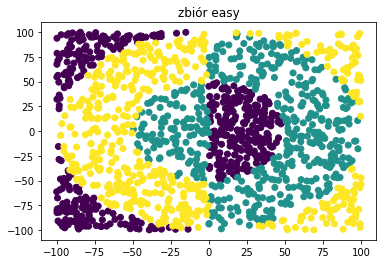

In [5]:
plt.scatter(train['x'], train['y'], c=train['c'])
plt.title('zbiór easy')
plt.show()

In [6]:
train_x = np.asarray(train.iloc[:,0:2])
train_y = np.asarray(train.iloc[:,2])

In [7]:
neat = NEAT(100, 2, 1)
neat.initialize()
neat.evolve(train_x, train_y, epochs=30)

/home/szwagier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:222: RuntimeWarning: overflow encountered in exp


0.5186666666666667

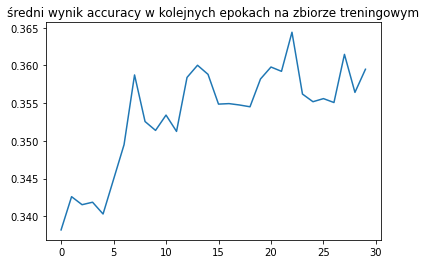

In [8]:
plt.plot([i for i in range(len(neat.generation_mean))], neat.generation_mean)
plt.title("średni wynik accuracy w kolejnych epokach na zbiorze treningowym")
plt.show()

In [9]:
preds = [neat.forward(neat.best, train_x[i])[0] for i in range(len(train_x))]
preds_class = []
for pred in preds:
    if pred < 0.5:
        preds_class.append(0)
    elif pred < 1.5:
        preds_class.append(1)
    else:
        preds_class.append(2)

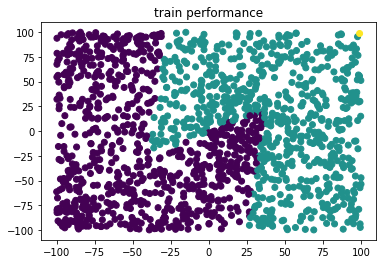

In [10]:
plt.scatter(train['x'], train['y'], c=preds_class)
plt.title('train performance')
plt.show()

Wyniki są bardzo słabe. Sprawdźmy czy preskalowanie danych do miejszych wartości trochę poprawi sytuację.

In [11]:
train_x_scaled = train_x/20

In [12]:
neat = NEAT(100, 2, 1)
neat.initialize()
neat.evolve(train_x_scaled, train_y, epochs=70)

0.542

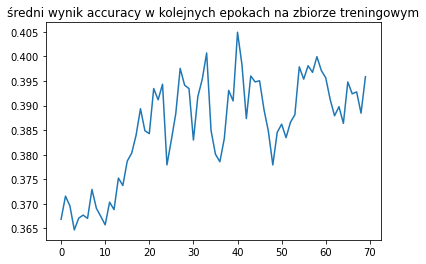

In [13]:
plt.plot([i for i in range(len(neat.generation_mean))], neat.generation_mean)
plt.title("średni wynik accuracy w kolejnych epokach na zbiorze treningowym")
plt.show()

In [14]:
preds = [neat.forward(neat.best, train_x_scaled[i])[0] for i in range(len(train_x))]
preds_class = []
for pred in preds:
    if pred < 0.5:
        preds_class.append(0)
    elif pred < 1.5:
        preds_class.append(1)
    else:
        preds_class.append(2)

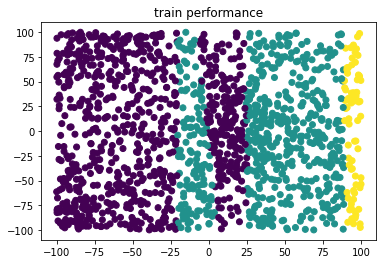

In [15]:
plt.scatter(train['x'], train['y'], c=preds_class)
plt.title('train performance')
plt.show()

Jest trochę lepiej ale nadal rezultat jest daleki od oczekiwanego. Próbujemy MAE

In [16]:
neat = NEAT(100, 2, 1)
neat.initialize()
neat.evolve(train_x_scaled, train_y, epochs=70, measure='MAE')

0.55

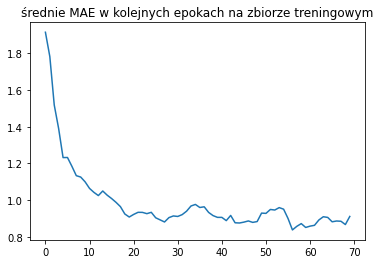

In [19]:
plt.plot([i for i in range(len(neat.generation_mean))], [1/v for v in neat.generation_mean])
plt.title("średnie MAE w kolejnych epokach na zbiorze treningowym")
plt.show()

In [20]:
preds = [neat.forward(neat.best, train_x_scaled[i])[0] for i in range(len(train_x))]
preds_class = []
for pred in preds:
    if pred < 0.5:
        preds_class.append(0)
    elif pred < 1.5:
        preds_class.append(1)
    else:
        preds_class.append(2)

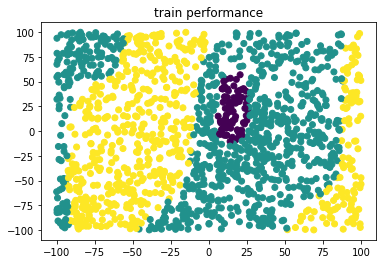

In [21]:
plt.scatter(train['x'], train['y'], c=preds_class)
plt.title('train performance')
plt.show()

Tu jest lepiej - widać, że klasa oznaczona kolorem fioletowym jakkolwiek przypomina połkole. Nie można powiedzieć jednak, że otrzymalismy zadowalająco dobrą sieć neuronową.